In [1]:
!pip install contractions
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import re
import string
import contractions
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import wordnet as wn, stopwords
from nltk.tokenize import word_tokenize
from nltk import ngrams

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df=pd.read_csv("/content/drive/My Drive/NLP_Learning/SPAM text message 20170820 - Data.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


### Data Clean

In [0]:
def text_clean(text):
    contraction=contractions.fix(text)
    nopunc = [char for char in contraction if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    text_list = word_tokenize(nopunc)
    non_stop=[word for word in text_list if word not in stopwords.words('english')]
    clean_text_list=[word.replace("\x92", "") for word in non_stop]
    clean_text=" ".join(clean_text_list)
    return clean_text.lower()

In [0]:
def transform_category(category):
    if category=="ham":
        return 0
    else:
        return 1

In [0]:
df_clean=df.copy()
df_clean["Message"]=df["Message"].apply(lambda x: text_clean(x))
df_clean["Category"]=df["Category"].apply(lambda x: transform_category(x))

In [8]:
df_clean.head(5)

,Category,Message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif oni
2,1,free entry 2 wkly comp win fa cup final tkts 2...
3,0,dun say early hor c already say
4,0,nah i think goes usf lives around though


### EDA & word cloud

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


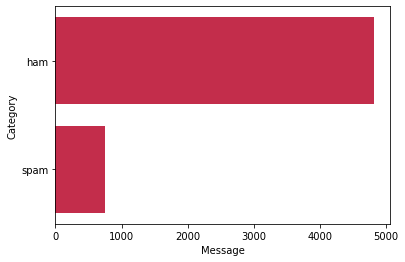

In [9]:
import seaborn as sns
df_count=df.groupby(by="Category").count().reset_index()
sns.barplot(x=df_count['Message'],y=df_count['Category'], color='crimson')

In [10]:
df.groupby(by="Category").count()

,Message
Category,
ham,4825
spam,747


In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def wc(data,bgcolor,title):
    plt.figure(figsize = (20,20))
    wc = WordCloud(background_color = bgcolor, max_words = 100,  max_font_size = 50)
    wc.generate(' '.join(data))
    plt.imshow(wc)
    plt.axis('off')

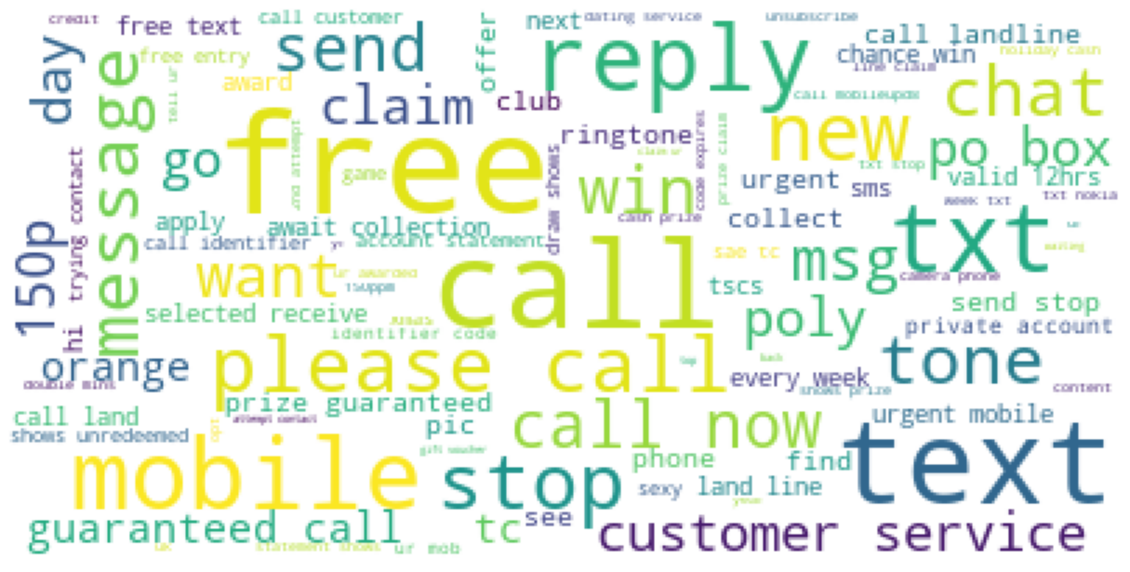

In [12]:
wc(df_clean["Message"][df_clean["Category"]==1],'white','Common Words' )

### Countvectorizor + RF

#### Train Test Split

In [13]:
# Set1 Regular train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_clean["Message"], df_clean["Category"],
                                                    stratify=df_clean["Category"],test_size=0.1,random_state=0)
print(len(y_train),len(y_test))

5014 558


In [14]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf=RandomForestClassifier(random_state=0)
pipe = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', rf),  # train on TF-IDF vectors w/ SVM
])

param_grid = {
    "classifier__n_estimators": [10,40,200],
    "classifier__max_depth":[10,50,100,200]
}
search = GridSearchCV(pipe, param_grid, cv=10,n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
prediction=search.predict(X_test)

Best parameter (CV score=0.974):
{'classifier__max_depth': 100, 'classifier__n_estimators': 200}


In [15]:
from sklearn.metrics import confusion_matrix, f1_score, auc,accuracy_score
print(f'Confusion matrix: \n{confusion_matrix(y_test, prediction)}')
print(f'F1 score:{f1_score(y_test, prediction)},\nAccuracy score:{accuracy_score(y_test, prediction)}')

Confusion matrix: 
[[483   0]
 [ 21  54]]
F1 score:0.8372093023255813,
Accuracy score:0.9623655913978495


#### Countvectorizor + Neural

In [0]:
from tensorflow import set_random_seed
from numpy.random import seed

In [0]:
# settingt the seed
seed(0)
set_random_seed(0)

In [18]:
from keras import Sequential, Model
from keras.layers import Dense,Dropout
from keras.callbacks import EarlyStopping
Max_Features=500
model1 = Sequential()
model1.add(Dense(units=500, activation='relu', input_dim=Max_Features))
model1.add(Dense(units=1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model1.summary()


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 501       
Total params: 251,001
Trainable params: 251,001
Non-trainable params: 0
_________________________________________________________________


In [19]:
epochs = 20
batch_size = 16
deep_pipeline = Pipeline([
    ('bow', CountVectorizer(max_features=Max_Features)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', model1),  # train on TF-IDF vectors w/ SVM
])
deep_pipeline.fit(X_train, y_train, classifier__epochs=epochs, classifier__batch_size=batch_size,
         classifier__validation_split=0.2,classifier__verbose=2,
         classifier__callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 4011 samples, validate on 1003 samples
Epoch 1/20
 - 1s - loss: 0.2298 - accuracy: 0.9150 - val_loss: 0.0804 - val_accuracy: 0.9801
Epoch 2/20
 - 1s - loss: 0.0707 - accuracy: 0.9788 - val_loss: 0.0641 - val_accuracy: 0.9761
Epoch 3/20
 - 1s - loss: 0.0495 - accuracy: 0.9833 - val_loss: 0.0635 - val_accuracy: 0.9761
Epoch 4/20
 - 1s - loss: 0.0364 - accuracy: 0.9890 - val_loss: 0.0683 - val_accuracy: 0.9781
Epoch 5/20
 - 1s - loss: 0.0294 - accuracy: 0.9910 - val_loss: 0.0729 - val_accuracy: 0.9811
Epoch 6/20
 - 1s - loss: 0.0246 - accuracy: 0.9920 - val_loss: 0.0764 - val_accuracy: 0.9831


Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=500, min_df=1, ngram_range=(1, 1),
                                 preprocessor=None, stop_words=None,
                                 strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 <keras.engine.sequential.Sequential object at 0x7f5a874820b8>)],
         verbose=False)

In [20]:
prediction_1=deep_pipeline.predict(X_test)
prediction1=np.where(prediction_1 > 0.5, 1, 0)
print(f'Confusion matrix: \n{confusion_matrix(y_test,prediction1)}')
print(f'F1 score:{f1_score(y_test, prediction1)},\nAccuracy score:{accuracy_score(y_test, prediction1)}')

Confusion matrix: 
[[478   5]
 [ 16  59]]
F1 score:0.8489208633093526,
Accuracy score:0.9623655913978495


### W2V + RF

In [0]:
from gensim.models import Word2Vec 
from nltk import word_tokenize,ngrams 

In [22]:
df_clean2=df_clean.copy()
df_clean2["Message"]=df_clean2["Message"].apply(lambda x: word_tokenize(x))
# df_clean2["Message_bigram"]=df_clean2["Message"].apply(lambda x: list(ngrams(x,2)))
df_clean2.head()

,Category,Message
0,0,"[go, jurong, point, crazy, available, bugis, n..."
1,0,"[ok, lar, joking, wif, oni]"
2,1,"[free, entry, 2, wkly, comp, win, fa, cup, fin..."
3,0,"[dun, say, early, hor, c, already, say]"
4,0,"[nah, i, think, goes, usf, lives, around, though]"


In [23]:
from sklearn.model_selection import train_test_split
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(df_clean2["Message"], df_clean2["Category"],
                                                    stratify=df_clean2["Category"],test_size=0.1)
print(len(y_train_w2v),len(y_test_w2v))

5014 558


In [0]:
model_w2v = Word2Vec(X_train_w2v, min_count=2,size= 20,workers=3, window =10, sg = 3)

In [25]:
model_w2v.wv.most_similar('think')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('night', 0.991878867149353),
 ('are', 0.9889335036277771),
 ('babe', 0.9889164566993713),
 ('do', 0.9873457551002502),
 ('well', 0.9864765405654907),
 ('hope', 0.9856724739074707),
 ('would', 0.9849267601966858),
 ('goes', 0.9831271171569824),
 ('what', 0.9829789996147156),
 ('much', 0.9825469851493835)]

In [0]:
def word_vector(tokens, size):
    vector = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vector += model_w2v.wv[word].reshape((1, size)) 
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vector /= count
    return vector

In [0]:
X_train_w2v_=np.concatenate([word_vector(x,20) for x in X_train_w2v])
X_test_w2v_=np.concatenate([word_vector(x,20) for x in X_test_w2v])

In [28]:
rf_wv=RandomForestClassifier(random_state=0)
param_grid = {
    "n_estimators": [10,40,200],
    "max_depth":[10,50,100,200]
}
search2 = GridSearchCV(rf_wv, param_grid, cv=10,n_jobs=-1)
search2.fit(X_train_w2v_, y_train_w2v)
print("Best parameter (CV score=%0.3f):" % search2.best_score_)
print(search2.best_params_)
prediction2=search2.predict(X_test_w2v_)

Best parameter (CV score=0.974):
{'max_depth': 10, 'n_estimators': 40}


In [29]:
print(f'Confusion matrix: \n{confusion_matrix(y_test_w2v, prediction2)}')
print(f'F1 score:{f1_score(y_test_w2v, prediction2)},\nAccuracy score:{accuracy_score(y_test_w2v, prediction2)}')

Confusion matrix: 
[[478   5]
 [ 10  65]]
F1 score:0.896551724137931,
Accuracy score:0.9731182795698925


#### W2V + Neural

In [30]:
model2 = Sequential()
model2.add(Dense(units=500, activation='relu', input_dim=X_train_w2v_.shape[1]))
model2.add(Dense(units=1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 500)               10500     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 501       
Total params: 11,001
Trainable params: 11,001
Non-trainable params: 0
_________________________________________________________________


In [31]:
epochs=30
batch_size = 16
model2.fit(X_train_w2v_, y_train_w2v, epochs=epochs, batch_size=batch_size,validation_split=0.2,verbose=2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 4011 samples, validate on 1003 samples
Epoch 1/30
 - 1s - loss: 0.1857 - accuracy: 0.9314 - val_loss: 0.1154 - val_accuracy: 0.9541
Epoch 2/30
 - 1s - loss: 0.1231 - accuracy: 0.9566 - val_loss: 0.1071 - val_accuracy: 0.9621
Epoch 3/30
 - 1s - loss: 0.1192 - accuracy: 0.9584 - val_loss: 0.1088 - val_accuracy: 0.9631
Epoch 4/30
 - 1s - loss: 0.1199 - accuracy: 0.9591 - val_loss: 0.1485 - val_accuracy: 0.9372
Epoch 5/30
 - 1s - loss: 0.1165 - accuracy: 0.9586 - val_loss: 0.1056 - val_accuracy: 0.9631
Epoch 6/30
 - 1s - loss: 0.1154 - accuracy: 0.9616 - val_loss: 0.1058 - val_accuracy: 0.9631
Epoch 7/30
 - 1s - loss: 0.1132 - accuracy: 0.9619 - val_loss: 0.1055 - val_accuracy: 0.9631
Epoch 8/30
 - 1s - loss: 0.1130 - accuracy: 0.9624 - val_loss: 0.1049 - val_accuracy: 0.9631
Epoch 9/30
 - 1s - loss: 0.1121 - accuracy: 0.9609 - val_loss: 0.1041 - val_accuracy: 0.9601
Epoch 10/30
 - 1s - loss: 0.1130 - accuracy: 0.9614 - val_loss: 0.1033 - val_accuracy: 0.9581
Epoch 11/30
 - 1s - l

In [32]:
prediction_3=model2.predict(X_test_w2v_)
prediction3=np.where(prediction_3 > 0.5, 1, 0)
print(f'Confusion matrix: \n{confusion_matrix(y_test_w2v,prediction3)}')
print(f'F1 score:{f1_score(y_test_w2v, prediction3)},\nAccuracy score:{accuracy_score(y_test_w2v, prediction3)}')

Confusion matrix: 
[[472  11]
 [ 12  63]]
F1 score:0.8456375838926175,
Accuracy score:0.9587813620071685


#### Embedding +Neural

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, CuDNNLSTM 

In [34]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 85
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(df_clean2['Message'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = tokenizer.texts_to_sequences(df_clean2['Message'].values)
X = pad_sequences(X,maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
Y = df_clean2['Category']

Found 9563 unique tokens.
Shape of data tensor: (5572, 85)


In [0]:
X_train_we, X_test_we, y_train_we, y_test_we = train_test_split(X, Y,
                                                    stratify=df_clean2["Category"],test_size=0.1,random_state=0)

In [36]:
from keras.layers import concatenate,SpatialDropout1D,Dropout
from keras import Sequential, Model
from keras.callbacks import EarlyStopping
import keras.layers as layers
model3 = Sequential()
model3.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model3.add(layers.Flatten())
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model3.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 85, 100)           5000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 8500)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 8501      
Total params: 5,008,501
Trainable params: 5,008,501
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
epochs = 30
batch_size = 16
model3.fit(X_train_we, y_train_we, epochs=epochs, batch_size=batch_size,validation_split=0.2,verbose=2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 4011 samples, validate on 1003 samples
Epoch 1/30
 - 1s - loss: 0.1995 - accuracy: 0.9267 - val_loss: 0.0680 - val_accuracy: 0.9821
Epoch 2/30
 - 1s - loss: 0.0391 - accuracy: 0.9903 - val_loss: 0.0472 - val_accuracy: 0.9890
Epoch 3/30
 - 1s - loss: 0.0167 - accuracy: 0.9963 - val_loss: 0.0415 - val_accuracy: 0.9890
Epoch 4/30
 - 1s - loss: 0.0090 - accuracy: 0.9980 - val_loss: 0.0410 - val_accuracy: 0.9890
Epoch 5/30
 - 1s - loss: 0.0049 - accuracy: 0.9990 - val_loss: 0.0407 - val_accuracy: 0.9910
Epoch 6/30
 - 1s - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0422 - val_accuracy: 0.9920
Epoch 7/30
 - 1s - loss: 0.0020 - accuracy: 0.9998 - val_loss: 0.0428 - val_accuracy: 0.9920
Epoch 8/30
 - 1s - loss: 0.0014 - accuracy: 0.9998 - val_loss: 0.0443 - val_accuracy: 0.9920


In [38]:
from sklearn.metrics import classification_report, confusion_matrix,f1_score, accuracy_score
prediction_4=model3.predict(X_test_we, batch_size = batch_size, verbose=2)
prediction4=np.where(prediction_4 > 0.5, 1, 0)
print(f'Confusion matrix: \n{confusion_matrix(y_test_we, prediction4)}')
print(f'F1 score:{f1_score(y_test_we, prediction4)},\nAccuracy score:{accuracy_score(y_test_we, prediction4)}')

Confusion matrix: 
[[482   1]
 [ 15  60]]
F1 score:0.8823529411764706,
Accuracy score:0.9713261648745519


#### Embedding+ CNN

In [39]:
model4 = Sequential()
model4.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model4.add(layers.Conv1D(128, 5, activation='relu'))
model4.add(layers.GlobalMaxPooling1D())
model4.add(layers.Dense(64, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 501       
Total params: 251,001
Trainable params: 251,001
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
epochs = 30
batch_size = 16
model4.fit(X_train_we, y_train_we, epochs=epochs, batch_size=batch_size,validation_split=0.2,verbose=2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 4011 samples, validate on 1003 samples
Epoch 1/30
 - 2s - loss: 0.1798 - accuracy: 0.9367 - val_loss: 0.0366 - val_accuracy: 0.9920
Epoch 2/30
 - 1s - loss: 0.0200 - accuracy: 0.9940 - val_loss: 0.0345 - val_accuracy: 0.9920
Epoch 3/30
 - 1s - loss: 0.0054 - accuracy: 0.9988 - val_loss: 0.0300 - val_accuracy: 0.9910
Epoch 4/30
 - 1s - loss: 0.0035 - accuracy: 0.9995 - val_loss: 0.0302 - val_accuracy: 0.9920
Epoch 5/30
 - 1s - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.0319 - val_accuracy: 0.9910
Epoch 6/30
 - 1s - loss: 2.6089e-04 - accuracy: 1.0000 - val_loss: 0.0360 - val_accuracy: 0.9890


In [41]:
from sklearn.metrics import classification_report, confusion_matrix,f1_score, accuracy_score
prediction_5=model4.predict(X_test_we, batch_size = batch_size, verbose=2)
prediction5=np.where(prediction_5 > 0.5, 1, 0)
print(f'Confusion matrix: \n{confusion_matrix(y_test_we, prediction5)}')
print(f'F1 score:{f1_score(y_test_we, prediction5)},\nAccuracy score:{accuracy_score(y_test_we, prediction5)}')

Confusion matrix: 
[[481   2]
 [ 14  61]]
F1 score:0.8840579710144927,
Accuracy score:0.9713261648745519


#### Embedding + LSTM

In [42]:
model5 = Sequential()
model5.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model5.add(SpatialDropout1D(0.2))
model5.add(LSTM(500, dropout=0.2, recurrent_dropout=0.2))
model5.add(Dense(1, activation='sigmoid'))
model5.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model5.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 85, 100)           5000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 85, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 500)               1202000   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 501       
Total params: 6,202,501
Trainable params: 6,202,501
Non-trainable params: 0
_________________________________________________________________
None


In [43]:
epochs = 20
batch_size = 32
model5.fit(X_train_we, y_train_we, epochs=epochs, batch_size=batch_size,validation_split=0.2,verbose=2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 4011 samples, validate on 1003 samples
Epoch 1/20
 - 11s - loss: 0.2034 - accuracy: 0.9339 - val_loss: 0.0812 - val_accuracy: 0.9781
Epoch 2/20
 - 11s - loss: 0.0458 - accuracy: 0.9868 - val_loss: 0.0467 - val_accuracy: 0.9880
Epoch 3/20
 - 11s - loss: 0.0174 - accuracy: 0.9950 - val_loss: 0.0513 - val_accuracy: 0.9880
Epoch 4/20
 - 10s - loss: 0.0083 - accuracy: 0.9973 - val_loss: 0.0609 - val_accuracy: 0.9850
Epoch 5/20
 - 10s - loss: 0.0127 - accuracy: 0.9975 - val_loss: 0.0516 - val_accuracy: 0.9880


In [44]:
from sklearn.metrics import classification_report, confusion_matrix,f1_score, accuracy_score
prediction_6=model5.predict(X_test_we, batch_size = batch_size, verbose=2)
prediction6=np.where(prediction_6 > 0.5, 1, 0)
print(f'Confusion matrix: \n{confusion_matrix(y_test_we, prediction6)}')
print(f'F1 score:{f1_score(y_test_we, prediction6)},\nAccuracy score:{accuracy_score(y_test_we, prediction6)}')

Confusion matrix: 
[[481   2]
 [ 12  63]]
F1 score:0.9,
Accuracy score:0.974910394265233


In [45]:
model6 = Sequential()
model6.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model6.add(SpatialDropout1D(0.2))
model6.add(LSTM(500, return_sequences=True,dropout=0.2, recurrent_dropout=0.2))
model6.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model6.add(Dense(1, activation='sigmoid'))
model6.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model6.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 85, 100)           5000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 85, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 85, 500)           1202000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               240400    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 101       
Total params: 6,442,501
Trainable params: 6,442,501
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
epochs = 20
batch_size = 32
model6.fit(X_train_we, y_train_we, epochs=epochs, batch_size=batch_size,validation_split=0.2,verbose=2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 4011 samples, validate on 1003 samples
Epoch 1/20
 - 20s - loss: 0.1565 - accuracy: 0.9456 - val_loss: 0.0525 - val_accuracy: 0.9860
Epoch 2/20
 - 19s - loss: 0.0321 - accuracy: 0.9908 - val_loss: 0.0450 - val_accuracy: 0.9860
Epoch 3/20
 - 19s - loss: 0.0135 - accuracy: 0.9958 - val_loss: 0.0555 - val_accuracy: 0.9821
Epoch 4/20
 - 19s - loss: 0.0071 - accuracy: 0.9980 - val_loss: 0.0809 - val_accuracy: 0.9731
Epoch 5/20
 - 19s - loss: 0.0029 - accuracy: 0.9998 - val_loss: 0.0595 - val_accuracy: 0.9860


In [47]:
from sklearn.metrics import classification_report, confusion_matrix,f1_score, accuracy_score
prediction_7=model6.predict(X_test_we, batch_size = batch_size, verbose=2)
prediction7=np.where(prediction_7 > 0.5, 1, 0)
print(f'Confusion matrix: \n{confusion_matrix(y_test_we, prediction7)}')
print(f'F1 score:{f1_score(y_test_we, prediction7)},\nAccuracy score:{accuracy_score(y_test_we, prediction7)}')

Confusion matrix: 
[[483   0]
 [ 13  62]]
F1 score:0.9051094890510949,
Accuracy score:0.9767025089605734


#### Elmo Embedding

In [0]:
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.engine import Layer
from tensorflow.keras.layers import Input, Lambda, Bidirectional, Dense, Dropout,LSTM
import tensorflow_hub as hub
import tensorflow as tf

class ElmoEmbeddingLayer(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable = True
        super(ElmoEmbeddingLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/3', trainable=self.trainable, name="{}_module".format(self.name))
        self.trainable_weights += K.tensorflow_backend.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ElmoEmbeddingLayer, self).build(input_shape)
    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1),
                      as_dict=True,
                      signature='default',
                      )['default']
        return result
    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')
    def compute_output_shape(self, input_shape):
      return (input_shape[0], self.dimensions)

In [49]:
input_text = layers.Input(shape=(1,), dtype=tf.string)
embedding = ElmoEmbeddingLayer()(input_text)
dense1 = layers.Dense(500, activation='relu')(embedding)
pred = layers.Dense(1, activation='sigmoid')(dense1)
model7 = Model(inputs=[input_text], outputs=pred)
model7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model7.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
elmo_embedding_layer_1 (Elmo (None, 1024)              4         
_________________________________________________________________
dense_10 (Dense)             (None, 500)               512500    
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 501       
Total params: 513,005
Trainable params: 513,005
Non-trainable params: 0
_________________________________________________________________


In [50]:
epochs=20
batchsize=16
model7.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,verbose=2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 4011 samples, validate on 1003 samples
Epoch 1/20
 - 20s - loss: 0.0729 - accuracy: 0.9746 - val_loss: 0.0437 - val_accuracy: 0.9860
Epoch 2/20
 - 17s - loss: 0.0291 - accuracy: 0.9913 - val_loss: 0.0850 - val_accuracy: 0.9721
Epoch 3/20
 - 17s - loss: 0.0234 - accuracy: 0.9930 - val_loss: 0.0371 - val_accuracy: 0.9890
Epoch 4/20
 - 17s - loss: 0.0150 - accuracy: 0.9945 - val_loss: 0.0472 - val_accuracy: 0.9870
Epoch 5/20
 - 17s - loss: 0.0098 - accuracy: 0.9970 - val_loss: 0.0601 - val_accuracy: 0.9840
Epoch 6/20
 - 17s - loss: 0.0058 - accuracy: 0.9983 - val_loss: 0.0644 - val_accuracy: 0.9880


In [51]:
prediction_8=model7.predict(X_test)
prediction8=np.where(prediction_8 > 0.5, 1, 0)
print(f'Confusion matrix: \n{confusion_matrix(y_test,prediction8)}')
print(f'F1 score:{f1_score(y_test, prediction8)},\nAccuracy score:{accuracy_score(y_test, prediction8)}')

Confusion matrix: 
[[482   1]
 [ 11  64]]
F1 score:0.9142857142857143,
Accuracy score:0.978494623655914
